In [1]:
#import requisite ilbraries
require('dplyr')

#import the data
library(Lahman)

#get the data
batting = merge(Master, Batting, by='playerID')

#First, CLEAN the data
## remove records with NA in the "bats" column (this is the player's batting hand)
batting = batting[!is.na(batting$bats),]

## remove all records before 1961 (1961 was the year the "modern" baseball season 
## of 162 games started, including prior years may skew results)
batting = batting[batting$yearID >= 1961,]

## Calculate batting average and include it as a new column in the data frame
batting$BA = batting$H / batting$AB

## remove records with no batting average and where batting average is above some 
## threshold - in this case 0.1
batting = batting[!is.na(batting$BA) & batting$BA >= 0.1,]

## name the columns
batting = batting[,c('playerID', 'birthYear', 'birthMonth', 'birthDay', 
                     'birthCity', 'birthState', 'birthCountry', 'nameFirst', 
                     'nameLast', 'weight', 'height', 'bats', 'throws', 'G', 
                     'AB', 'H', 'BA')]

## include a column for the player's entire name 
## (concatenation of nameFirst and nameLast columns)
batting$fullName =  paste(batting$nameFirst, batting$nameLast)

## select only the columns we'll use for this analysis
batting_df = select(batting, playerID, G:BA)

## group the data frame by playerID
players = group_by(batting_df, playerID)

## summarize player information - creates one row for each player 
## (originally have one row for each year a player played)
players = summarise(players, H = sum(H), AB = sum(AB), G = sum(G), 
                    BA = round(mean(BA), 3), total_rows = n())

## drop any duplicate records from the batting data frame
deduped_batting <- batting[!duplicated(batting$playerID),]

## merge the deduplicated batting dataframe with the player dataframe 
## containing only one row per player
new_batting = merge(players, deduped_batting, by="playerID")

## select only the columns we want in this new data frame
new_batting = select(new_batting, playerID:throws, fullName)

## name the columns
colnames(new_batting) = c('playerID','H','AB','G','BA','totalYears','birthYear',
                          'birthMonth','birthDay','birthCity','birthState',
                          'birthCountry','nameFirst','nameLast','weight','height',
                          'bats','throws','fullName')

## remove any records where the player played less than 162 games 
## (that would be less than one season, so could also skew data, could have 
## abnormally high or low batting average based on limited number of at bats.)
new_batting = new_batting[new_batting$G >= 162,]

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'Lahman' was built under R version 3.4.2"

In [2]:
## create dataframe containing only US-born players
batting_us <- new_batting[new_batting$birthCountry == 'USA',]

## create datframe containing only international players -- to be used at a later point 
batting_intl <- new_batting[new_batting$birthCountry != 'USA',]

# Introduction

Often considered "America's Past-time", baseball is a sport that has been played for over a century in the United States, and which is a part of a history of bat-and-ball sports that spans back even further. Luckilly, statistics and performance tracking have been at the core of baseball since its inception; this paper will analyze these statistics in the attempt to expose interesting and unique trends in the history of the game. 

## What is Baseball?
Baseball is a game comprised of, you guessed it, a ball and some bases (as well as bats, gloves, bases, and a few other accessories). Broadly speaking, baseball is played as follows:

- the pitcher 'pitches' (throws) the ball, and the batter (the person holding the bat) tries to hit it.
- If the batter swings and misses at the ball three times, s/he is out. 
- If the ball is hit and is caught before it touches the ground, the batter is out. 
- If the ball touches the ground before it is caught, however, the batter attempts to touch as many bases as possible before it becomes dangerous to do so (for example, the ball is at the base one further than the one s/he is at now, so the batter stays at their current base). 
- If the batter hits the ball over the far-opposite field from where s/he is batting, it's a homerun. The batter is able to touch all bases freely. 
- If a batter touches all bases, they reach 'home' (the last base is called 'homebase'), and it is counted as a run. 
- Each team gets 3 outs per inning.
- A game normally lasts 9 innings, unless there is a tie. In this case, the teams play until one has more runs than the other.
- At the end of the game, the team with the most runs wins. 

There are other rules beyond the above-mentioned that need to be followed when playing baseball, but these suffice to give the reader an understanding of the purpose of the game and how it is played. For a greater understanding, here are definitions of additional terms that will be used in the course of this analysis:

- Single (H): the batter reaches 1st base.
- Double (X2B): the batter reaches 2nd base.
- Triple (X3B): the batter reaches 3rd base.
- Home Run (HR): the batter hits a home run.
- Runs Batted In (RBI): the number of runners on base a player brings home.
- Runs (R): the number of times a batter has crossed home plate.
- Games (G): the number of games played.
- At Bats (AB): the number of times a player has batted.
- Batting Average (BA): a player's total number of hits divided by the number of his/her at bats. Anything above .250 is considered good; it is abnormal for players to consistently reach higher than .300.

## History of Baseball
(if you've got a free hour on your hands, check out this [riveting video](https://www.youtube.com/watch?v=HMZzsV3xi8Q) on the history of the game).

## Lahman Dataset
The Lahman baseball dataset was created, and is still managed, by Sean Lahman, a database journalist (for more information on Mr. Lahman, [check out his website](http://seanlahman.com/)). The data is provided in myriad formats - as a set of CSV files, as a set of SQL tables, as an R library, among others - and is free and readily available on the Internet, either from Mr. Lahman's personal website or a variety of other souces. The dataset is updated after each season, and goes back all the way to 1871, the year the [National Association of Professional Base Ball Players was founded](http://www.history.com/this-day-in-history/national-league-of-baseball-is-founded) (the name has since changed to something more manageable, Major League Baseball).

The breadth and depth of the dataset is impressive, covering a variety of player-, team-, and franchise-related information. Here are just a smattering of the tables included in the dataset:

- Fielding statistics
- Batting statistics
- Pitching statistics 
- Post-Season/Playoff statistics
- Awards lists
- Team Manager information
- All Star game appearances
- Salary information
- Collegiate-level information
- Hall of Fame information

The source of the dataset for this paper is the [Lahman R Package](https://cran.r-project.org/web/packages/Lahman/Lahman.pdf).

## Paper Scope
In this paper, we will be focusing primarily on the fielding, batting, and pitching statistics tables of the Lahman dataset. All statistics before the year 1961 have been dropped for statistical accuracy, as 1961 is the [first  year the "modern" baseball season](http://www.thesportshistorian.com/why-162-games/#) of 162 games was played (yes, the baseball season is 162 games long - not including playoffs!).

# Seeing the Data

First we will discuss how the data was structured and cleansed to be more usable and user-friendly for our analysis. After, we will do some visualizations to get a better idea of what our data looks like and how it is distributed. Each section will be broken down by data subject to more clearly and easily show the unique steps taken for cleansing and visualizing the two different dataframes.

## Loading and Cleaning the Data

Because the dataset is so large, the first thing to do is reduce the information down to what we're interested in, which is batting and pitching statistics by player from 1961 onwards. To do this, we first load the Lahman R package and import the requisite dataframes - in this case, the Master (general player information), Batting (player batting statistics), and Pitching (player pitching specifics) dataframes. We are lucky in that the data is already formatted as R dataframes.

### Cleaning the Batting Data

Starting with the Batting and Master dataframes, we merge these together by the playerID column (each player is identified by a unique playerID on each player-related table). Next, omit any records where the batting information is missing or incomplete,  and drop all rows that are from 1960 or before. After this, we calculate each player's batting average by dividing the hitting column (H) by the at-bats column (AB). Each player has multiple records in this iteration of the merged master/batting dataframe, yet what we actually want is one summated row of statistics per player. To reach this final point, we group the dataframe by playerID, and use the summarise function to perform the requisite summation statistics per player. The batting dataframe is now ready for analysis!

### Cleaning the Pitching Data

## Visualizing the Game

Let's see what we're dealing with! First, we'll take a look at our newly created batting statistics dataframe; after this, we'll take a visual tour of our pitching dataframe.

### Seeing the Swing
First off, it's important to get an idea of the breadth and distribution of our batting dataframe. In regards to structure, our batting dataframe has 19 columns and 3202 rows (that means 3202 individual player records). Using the str() function, we see that there are both continuous and factorial variables in this dataset, albeit the continuous variables dominate. 

In [3]:
str(new_batting)

'data.frame':	3202 obs. of  19 variables:
 $ playerID    : chr  "aaronha01" "aaronto01" "abbotje01" "abbotku01" ...
 $ H           : int  2462 216 157 523 86 210 12 191 2470 537 ...
 $ AB          : int  8250 944 596 2044 386 834 53 840 8480 1793 ...
 $ G           : int  2259 437 233 702 180 220 257 392 2425 458 ...
 $ BA          : num  0.294 0.221 0.247 0.251 0.239 0.25 0.256 0.221 0.281 0.3 ...
 $ totalYears  : int  16 7 5 10 3 3 5 7 20 3 ...
 $ birthYear   : int  1934 1939 1972 1969 1980 1977 1933 1966 1974 1987 ...
 $ birthMonth  : int  2 8 8 6 7 9 3 6 3 1 ...
 $ birthDay    : int  5 5 17 2 15 23 6 17 11 29 ...
 $ birthCity   : chr  "Mobile" "Mobile" "Atlanta" "Zanesville" ...
 $ birthState  : chr  "AL" "AL" "GA" "OH" ...
 $ birthCountry: chr  "USA" "USA" "USA" "USA" ...
 $ nameFirst   : chr  "Hank" "Tommie" "Jeff" "Kurt" ...
 $ nameLast    : chr  "Aaron" "Aaron" "Abbott" "Abbott" ...
 $ weight      : int  180 190 190 180 215 185 215 190 220 255 ...
 $ height      : int  72 75 74

For a more interesting analysis, we will convert a few of the character columns into factors (birthMonth, birthState, and birthCountry) to go along with our existing bats and throws factor columns.

In [4]:
## convert the below columns from chr to factor
new_batting$birthMonth <- as.factor(new_batting$birthMonth)
new_batting$birthState <- as.factor(new_batting$birthState)
new_batting$birthCountry <- as.factor(new_batting$birthCountry)

Using the summary() function gives us a good overview of the distribution of our data. Some variables, like H and AB, have a much greater variability in the distribution of their values, while others - like BA - are much more narrowly distributed. 

In [5]:
summary(new_batting)

   playerID               H                AB              G         
 Length:3202        Min.   :   2.0   Min.   :    4   Min.   : 162.0  
 Class :character   1st Qu.: 150.0   1st Qu.:  658   1st Qu.: 287.0  
 Mode  :character   Median : 388.5   Median : 1556   Median : 570.5  
                    Mean   : 626.5   Mean   : 2378   Mean   : 769.9  
                    3rd Qu.: 918.0   3rd Qu.: 3545   3rd Qu.:1104.0  
                    Max.   :4256.0   Max.   :14053   Max.   :3562.0  
                                                                     
       BA           totalYears       birthYear      birthMonth  
 Min.   :0.1220   Min.   : 2.000   Min.   :1920   8      : 323  
 1st Qu.:0.2260   1st Qu.: 6.000   1st Qu.:1947   10     : 307  
 Median :0.2460   Median : 9.000   Median :1962   12     : 274  
 Mean   :0.2448   Mean   : 9.498   Mean   :1962   11     : 269  
 3rd Qu.:0.2650   3rd Qu.:12.000   3rd Qu.:1976   1      : 262  
 Max.   :0.7780   Max.   :29.000   Max.   :1994   

#### Histograms and Boxplots
Below are histograms for each of our continous variables.

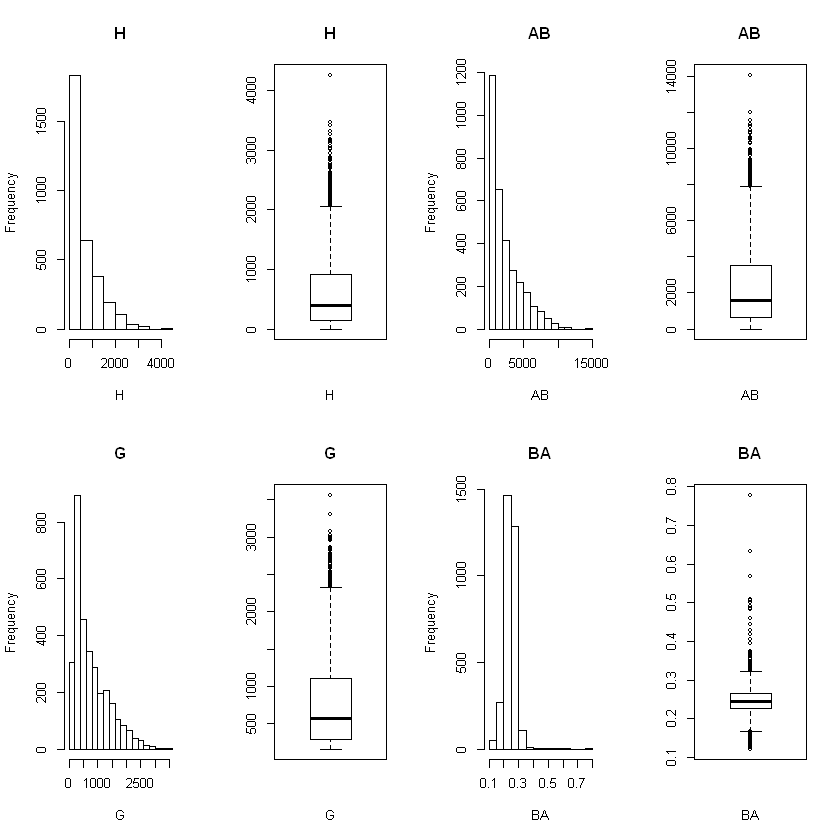

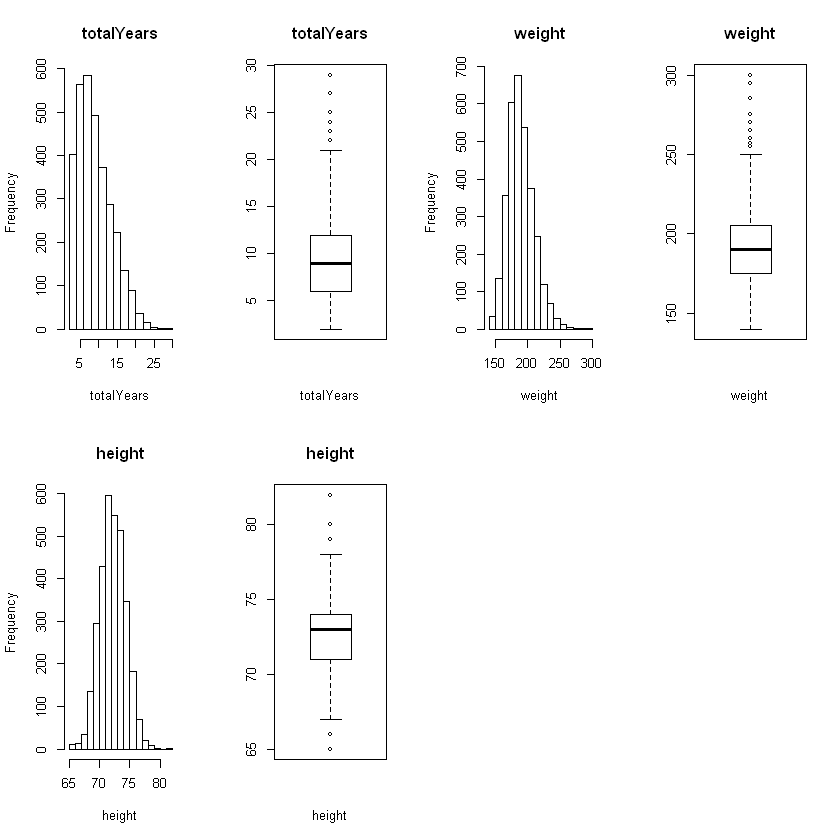

In [6]:
continuous_cols = c('H', 'AB', 'G', 'BA', 'totalYears', 'weight', 'height')
par(mfrow = c(2,4))

for (c in continuous_cols) {
    hist(new_batting[[c]], main = c, xlab = c)
    boxplot(new_batting[[c]], main = c, xlab = c)
}

We can see that, as described in the dataframe summary, batting average is normally distributed  (albeit tightly so) and hits and at-bats are right-skewed distributions. This right-skewness actually seems to hold for all continuous variables other than batting average, height, and weight which, when you think about it, does make sense: there are many more players who have played a short amount of time than those who have played a long time, and therefore the total number of records for hits, at-bats, games, and total years played are dominated by these records.

#### Factorial Variable Bar Charts

We can get an idea of the cross-category distribution of our factor variables by plotting them as bar charts. Below is the result of plotting bats, throws, birthState, birthCountry, and birthMonth.

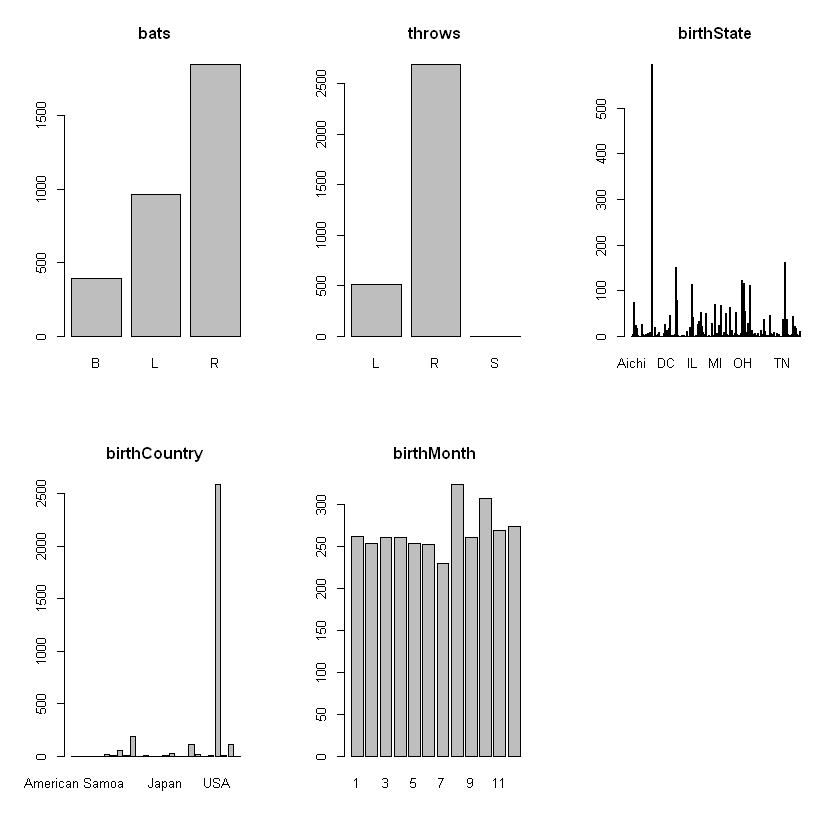

In [7]:
batting_factors <- c('bats', 'throws', 'birthState', 'birthCountry', 'birthMonth')

par(mfrow = c(2,3))

for (b in batting_factors) {
    plot(new_batting[[b]], main = b)
}


The first thing that stands out is the number of right-handed batters/hitters compared to left-handed or switch hitters (B) / switch throwers (S) (a switch hitter/thrower is someone who is ambidextrous enough to compete with both hands). The number of players born in the USA is quite larger than that of any other country, but that is apparent given that Major League Baseball is based in the United States. This also plays into the player totals by US State - albeit hard to see at this scale, the number of players from California dominates over other states. And in a somewhat bizarre result, the data shows that the greatest number of baseball players were born in August and October! 

We will now look into a couple of these variables to see if we can find any surprising outcomes. For this analysis, we will further explore birthCountry, birthState, and birthMonth.

##### Players by Country

We know that the US is home to a great many baseball players since baseball is such a popular sport there. What we'd like to expand upon is the number of players that come from other countries, and if there is any geographical relationship between these countries. 

First, we remove the US from the dataset. This is the new bar chart omitting the United States:

In [8]:
new_fielding <- merge(Master, Fielding, 'playerID') 
new_fielding <- new_fielding[new_fielding$yearID >= '1961',]
new_fielding <- new_fielding[c('playerID','POS','birthCountry','birthState')]

grouped_fielding <- group_by(new_fielding, playerID)
grouped_fielding <- summarise(grouped_fielding, total_rows = n())

merged_fielding <- merge(grouped_fielding, new_fielding, 'playerID')

## drop any duplicate records from the batting data frame
fielding_player <- merged_fielding[!duplicated(merged_fielding$playerID),]
fielding_player$total_rows <- NULL
fielding_player$playerID <- NULL
fielding_player$birthState <- NULL
fielding_player_intl <- fielding_player[fielding_player$birthCountry != 'USA',]
fielding_player_intl <- na.omit(fielding_player_intl)

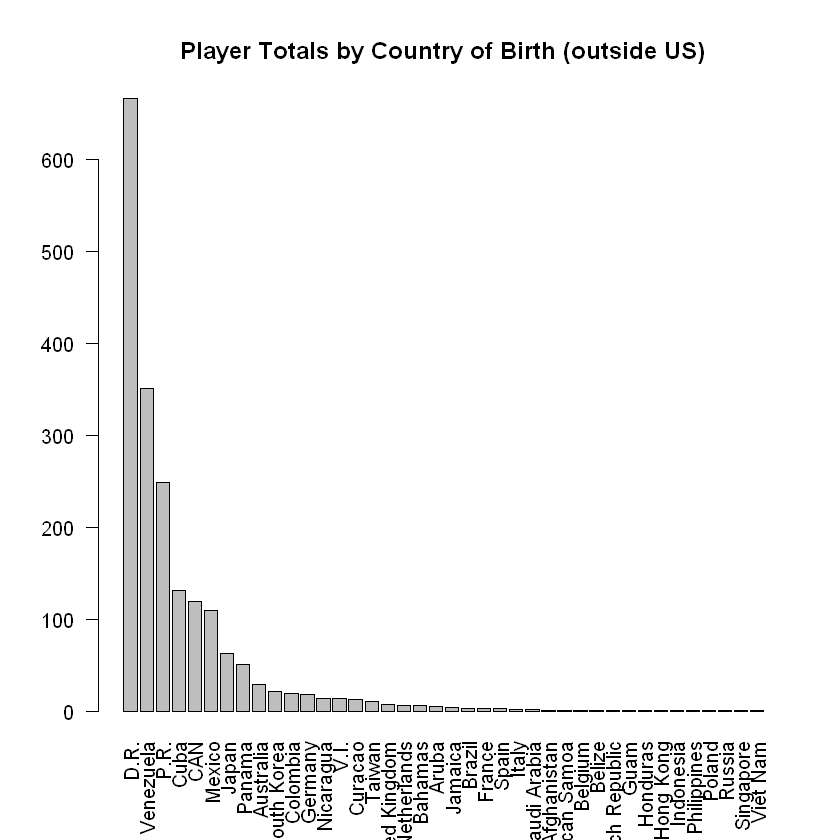

In [9]:
## INTERNATIONAL BATTING AND FIELDING TOTALS DO NOT MATCH
# set the levels in order we want
intl_births_fielding <- within(fielding_player_intl, 
                   birthCountry <- factor(birthCountry, 
                                      levels=names(sort(table(birthCountry), 
                                                        decreasing=TRUE))))

## ordered by total by country, highest to lowest
plot(intl_births_fielding$birthCountry, main = 'Player Totals by Country of Birth (outside US)', las=2)

The Latin American world certainly appears to be the most represented, with the Dominican Republic, Venezuela, and Cuba rounding out the top three countries for players of non-US origin.

#### World Map of Player Birth Country
Viewing player birth country on a map provides a stunning visual display of the dispersion (or lack thereof) of professional baseball. Let's take a look:

Warning message:
"Unknown or uninitialised column: 'birthCountryShort'."Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.4.3"### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')


41 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
202 codes from the map weren't represented in your data


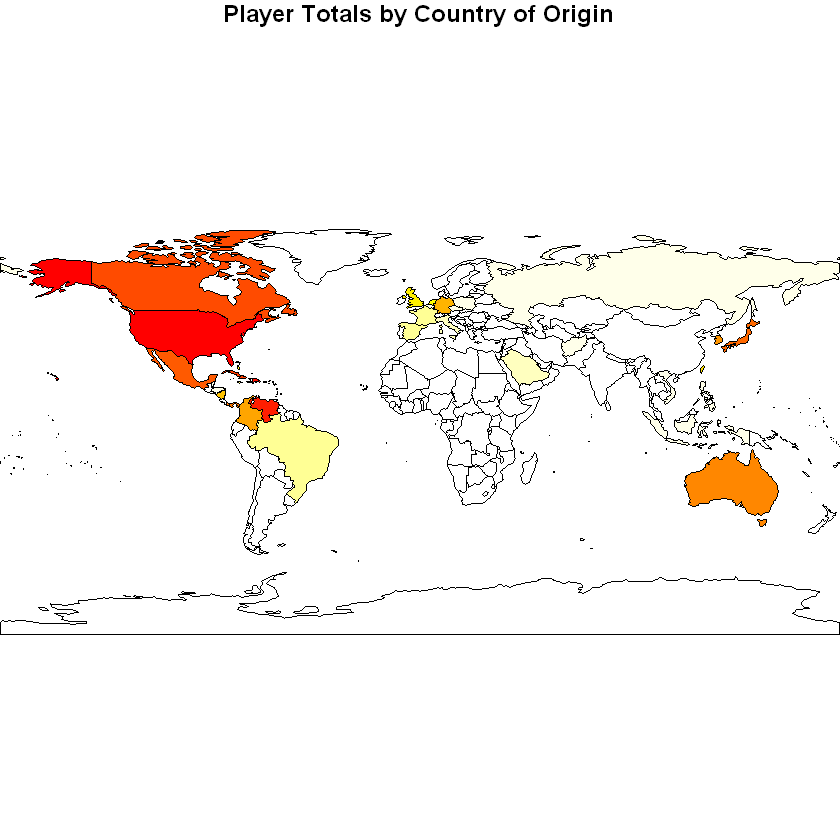

In [10]:
## convert the country names to ISO-3 country codes (for world mapping)
## get unique country names
country_names <- sort(as.character(unique(fielding_player$birthCountry)), decreasing=FALSE)

## country codes needed for mapping - UPDATE TO INCLUDE NEW COUNTRIES IN FIELDING DATAFRAME
new_ctry_codes <- c('AFG', 'ASM', 'ABW', 'AUS', 'BHS', 'BEL', 'BLZ', 'BRA', 'CAN', 'COL', 
                    'CUB', 'CUW', 'CZE', 'DOM', 'FRA', 'DEU', 'GUM', 'HND', 'HKG', 'IDN', 'ITA',
                    'JAM', 'JPN', 'MEX', 'NLD', 'NIC', 'PRI', 'PAN', 'PHL', 'POL', 'RUS', 
                    'SAU', 'SGP', 'KOR', 'ESP', 'TWN', 'GBR', 'USA', 'VIR', 'VEN', 'VNM')

## create "dictionary" of current names with new names
names(new_ctry_codes) <- country_names

# ## convert countries back to characters in dataframe
#new_batting$birthCountry <- as.character(new_batting$birthCountry)

##create small dataframe with countries and total players per country
country_totals_fielding <- group_by(fielding_player, birthCountry)
country_totals_fielding <- summarise(country_totals_fielding, playersTotal = n())

for (country in country_names) {
  country_totals_fielding$birthCountryShort[country_totals_fielding$birthCountry == country] <- new_ctry_codes[country]
    }

## map the countries of origin and their size on a world map - all countries
library(rworldmap)
map_data <- joinCountryData2Map(country_totals_fielding, joinCode = 'ISO3', nameJoinColumn = 'birthCountryShort')
# mapDevice()   ### this creates pop-out image of map in RSTUDIO ONLY
par(mai=c(0,0,0.2,0),xaxs="i",yaxs="i")

mapParams <- mapCountryData(map_data, addLegend = FALSE,
                            catMethod = 'categorical',
                            mapTitle = "Player Totals by Country of Origin",
                            colourPalette = "heat",
                            borderCol = "black", 
                            nameColumnToPlot = 'playersTotal')

This map puts in stark relief the regionality of baseball (country totals go from white to red). Professional players have only 26 countries of origin in the game's history, the vast majority of which are within the Americas/Caribbean and the greater Pacific Rim region. It is somewhat ironic, then, that the baseball championship is called the World Series when so little of the world is actually represented by (and therefore likely not interested in) the game.

In [11]:
library(dplyr)

##group by birthCountry and POS to get all positions for each country
grp_pos_ctry <- fielding_player_intl %>% count(birthCountry, POS)
colnames(grp_pos_ctry)[3] <- 'players'
head(grp_pos_ctry)

birthCountry,POS,players
Afghanistan,P,1
American Samoa,1B,1
Aruba,OF,1
Aruba,P,3
Aruba,SS,1
Australia,1B,3


In [12]:
##get max POS value by country (now have most players from each position for each country)
df.agg <- aggregate(players ~ birthCountry, grp_pos_ctry, max)
# then simply merge with the original
df.max <- merge(df.agg, grp_pos_ctry)
head(df.max)

birthCountry,players,POS
Afghanistan,1,P
American Samoa,1,1B
Aruba,3,P
Australia,20,P
Bahamas,4,OF
Belgium,1,OF


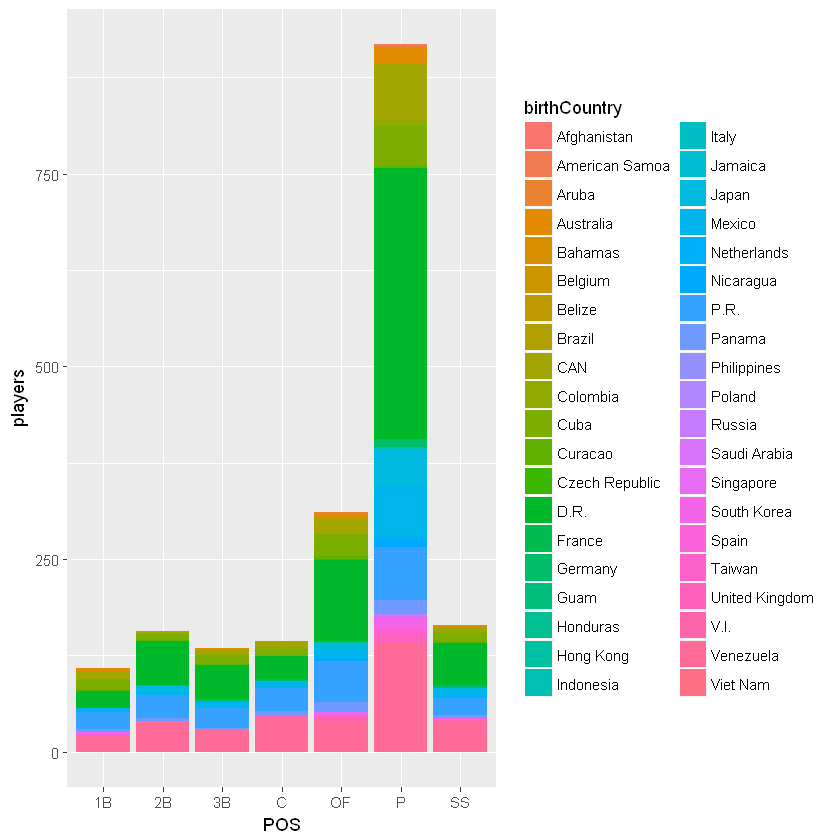

In [13]:
## group position by total players from each country

library(dplyr)
library(ggplot2)

ggplot(grp_pos_ctry %>%    # Group by region and species, then count number in each group
         mutate(pct=players/sum(players),               # Calculate percent within each region
                ypos = cumsum(players) - 0.5*players),  # Calculate label positions
       aes(POS, players, fill=birthCountry)) +
  geom_bar(stat="identity")

In [14]:
## Graph position by country - one graph per position, showing a bar for each country for that position (so 7 graphs total)
## to give a better view of the stacked totals by country by position above

Loading required package: gridExtra
Warning message:
"package 'gridExtra' was built under R version 3.4.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



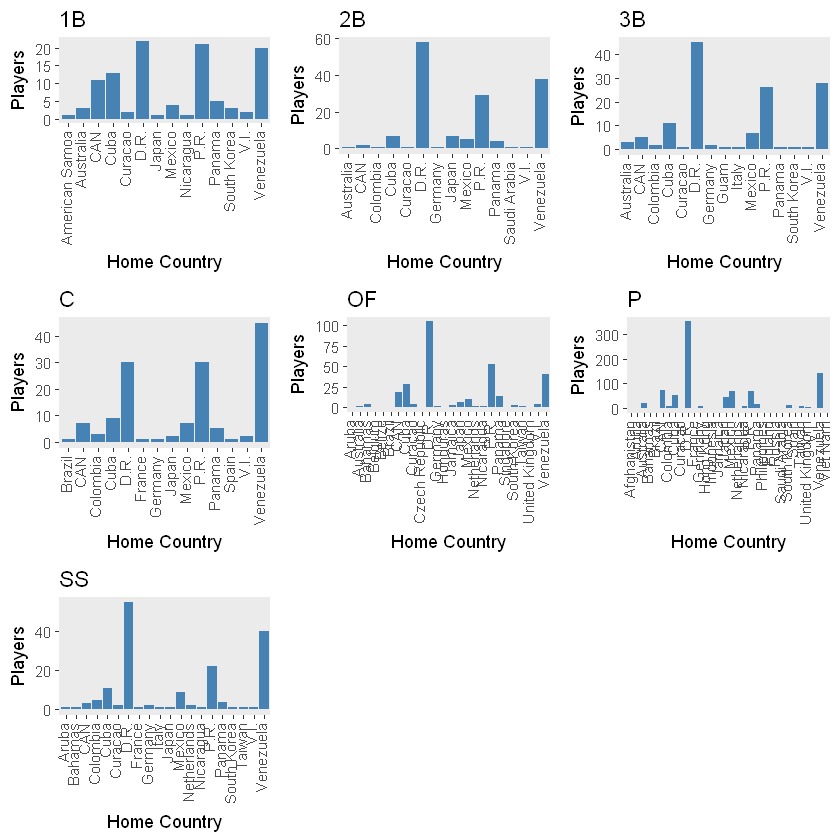

In [15]:
require(gridExtra)

position_plot <- function(df, position) {
    plot_pos <- df[df$POS == position,]
    pos_plot <- ggplot(data=plot_pos, aes(x = birthCountry, y = players, fill=variable)) +
                    geom_bar(stat='identity', fill = 'steelblue') +
                    ggtitle(position) + xlab('Home Country') + ylab('Players') +
    #                 geom_text(aes(label = playerRatio), vjust = 1.6, color = 'white', size = 1.5) +
                    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .2)) +
    #                 scale_y_continuous(limits = c(0, 0.171), expand = c(0,0)) +
                    theme(panel.grid = element_blank(), panel.border = element_blank())
}

first_plot <- position_plot(grp_pos_ctry, '1B')
second_plot <- position_plot(grp_pos_ctry, '2B')
third_plot <- position_plot(grp_pos_ctry, '3B')
c_plot <- position_plot(grp_pos_ctry, 'C')
of_plot <- position_plot(grp_pos_ctry, 'OF')
p_plot <- position_plot(grp_pos_ctry, 'P')
ss_plot <- position_plot(grp_pos_ctry, 'SS')

grid.arrange(first_plot, second_plot, third_plot, c_plot, of_plot, p_plot, ss_plot, ncol=3)

Because the greatest number of players come from the United States - 2586 in total, which, since the MLB was founded and is based in the US, makes sense - we'll now spend some time digging into state-by-state player comparisons.

In [16]:
############ NEW STUFF ###################
fielding_states <- merged_fielding[!duplicated(merged_fielding$playerID),]
fielding_states <- fielding_states[fielding_states$birthCountry == 'USA',]

##create small dataframe with states and total players per state
state_totals <- group_by(fielding_states, birthState)
state_totals <- summarise(state_totals, playersTotal = n())

states_abbrev <- c('AL',	'AK',	'AZ',	'AR',	'CA',	'CO',	'CT','DC', 	'DE',	'FL',	'GA',	'HI',	'ID',	'IL',
           'IN',	'IA',	'KS',	'KY',	'LA',	'ME',	'MD',	'MA',	'MI',	'MN',	'MS',	'MO',	'MT',
           'NE',	'NV',	'NH',	'NJ',	'NM',	'NY',	'NC',	'ND',	'OH',	'OK',	'OR',	'PA',	'RI',
           'SC',	'SD',	'TN',	'TX',	'UT',	'VT',	'VA',	'WA',	'WV',	'WI',	'WY')

states_full <- c('Alabama', 
'Alaska', 
'Arizona', 
'Arkansas', 
'California', 
'Colorado', 
'Connecticut',
'Washington D.C.',
'Delaware', 
'Florida', 
'Georgia', 
'Hawaii', 
'Idaho', 
'Illinois', 
'Indiana', 
'Iowa', 
'Kansas', 
'Kentucky', 
'Louisiana', 
'Maine', 
'Maryland', 
'Massachusetts', 
'Michigan', 
'Minnesota', 
'Mississippi', 
'Missouri', 
'Montana', 
'Nebraska', 
'Nevada', 
'New Hampshire', 
'New Jersey', 
'New Mexico', 
'New York', 
'North Carolina', 
'North Dakota', 
'Ohio', 
'Oklahoma', 
'Oregon', 
'Pennsylvania', 
'Rhode Island', 
'South Carolina', 
'South Dakota', 
'Tennessee', 
'Texas', 
'Utah', 
'Vermont', 
'Virginia', 
'Washington', 
'West Virginia', 
'Wisconsin', 
'Wyoming')

## create "dictionary" of current names with new names
names(states_abbrev) <- states_full

# replace state names with full names - NOT WORKING
for (state in states_full) {
    state_totals[state_totals$birthState == states_abbrev[[state]],] $birthState <- state
}

# order dataframe alphabetically by state
state_totals <- state_totals[order(state_totals$birthState),]

## generate barplot of players from US State by total current population for each state - is there a relationship?
library(readxl)

# load in state population dat
state_pop <- read_excel('C:/Users/5SQQJ72/Documents/leuphana/courses/software_for_analyzing_data/baseball_project/us_states_by_pop.xlsx')

# merge state pops with player totals from each state
states_players_pop <- merge(state_pop, state_totals, by.x= "state", by.y = "birthState")

# divide state population by 10,000 to make the plotting meaningful
states_players_pop$popEstimate <- round(states_players_pop$popEstimate / 10000, 0)

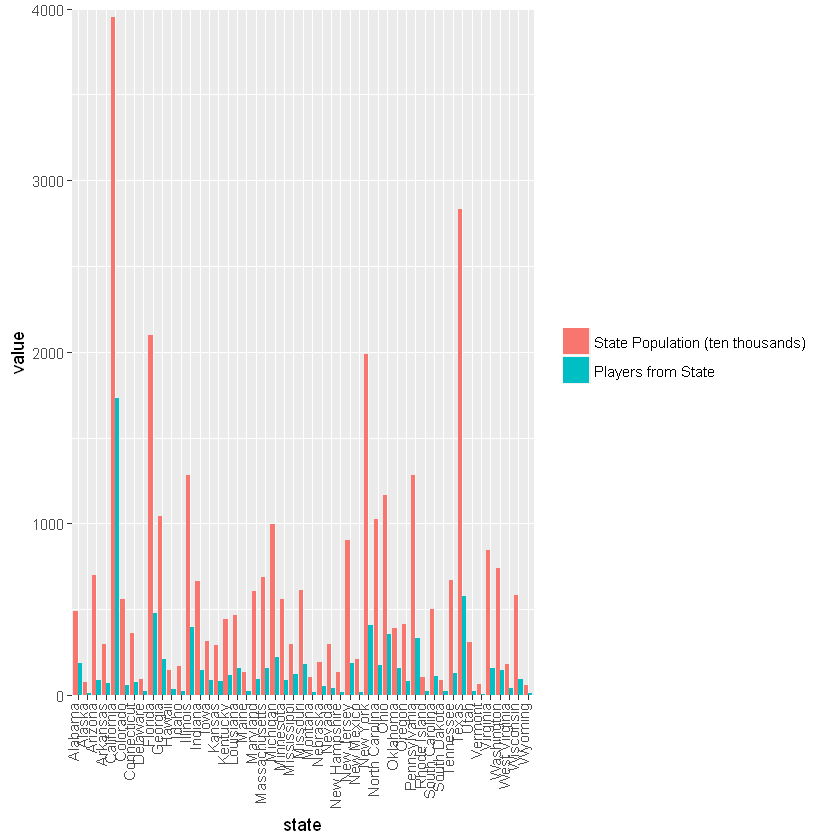

In [17]:
library(ggplot2)
library(reshape2)

# barplot of state population against players from each state
states_long <- melt(states_players_pop, id.vars = 'state')

ggplot(states_long, aes(state, value, fill=variable)) + scale_fill_discrete(name=NULL,
                        breaks=c("popEstimate", "playersTotal"),
                        labels=c("State Population (ten thousands)", "Players from State")) +
                        geom_bar(position="dodge",stat="identity")  +
                        scale_y_continuous(limits = c(0, 4000), expand = c(0,0)) +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0)) +
  ggsave(file='pop_players_by_state.png', width = 16, height = 9, dpi = 120)

Warning message:
"package 'fiftystater' was built under R version 3.4.3"

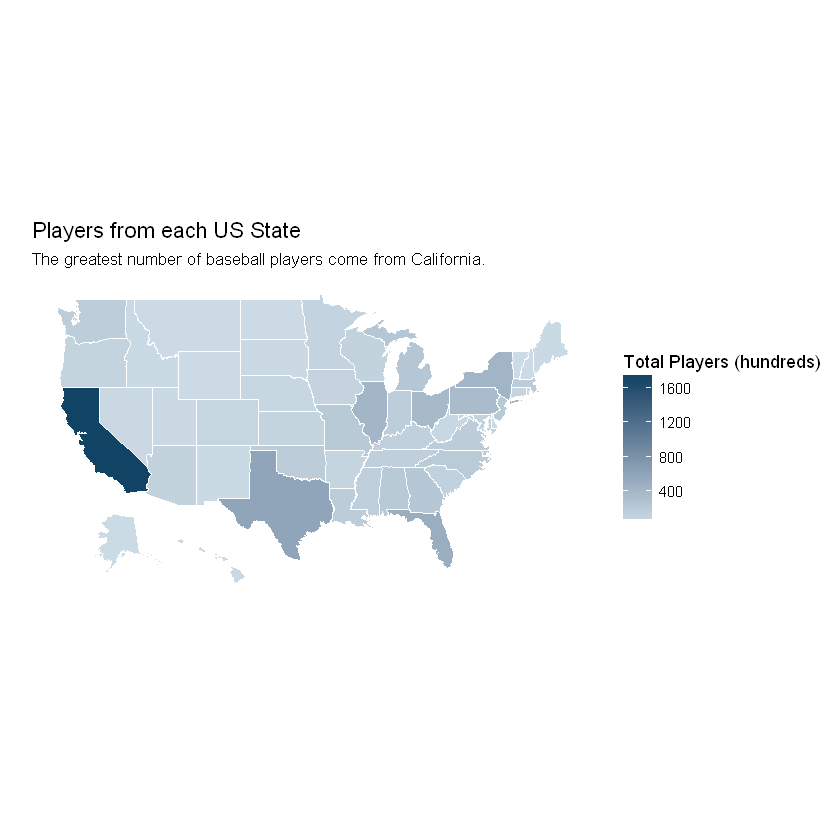

In [18]:
library(ggplot2)
library(fiftystater)

# set states to lowercase
state_totals$birthState <- tolower(state_totals$birthState)

## map the results of players by state on a US-wide heatmap (darker colored states having more players from them)


####################################
# chloropleth map of state player totals
####################################
low_color='#ccdbe5' 
high_color="#114365"
legend_title = 'Total Players (hundreds)'
ggplot(state_totals, aes(map_id = birthState)) + 
  geom_map(aes(fill = playersTotal),color="#ffffff",size=.15, map = fifty_states) + 
  expand_limits(x = fifty_states$long, y = fifty_states$lat) +
  coord_map() +
  labs(x = "", y = "") +
  scale_x_continuous(breaks = NULL) + 
  scale_y_continuous(breaks = NULL) +
  scale_fill_continuous(low = low_color, high= high_color, guide = guide_colorbar(title = legend_title)) + # creates shading pattern
  theme(#legend.position = "bottom", 
    panel.background = element_blank()) + 
  #fifty_states_inset_boxes() +
  ggtitle('Players from each US State', subtitle = 'The greatest number of baseball players come from California.')

,state,playerRatio
5,California,0.44
24,Mississippi,0.42
35,Oklahoma,0.40
1,Alabama,0.38
18,Louisiana,0.34
13,Illinois,0.31


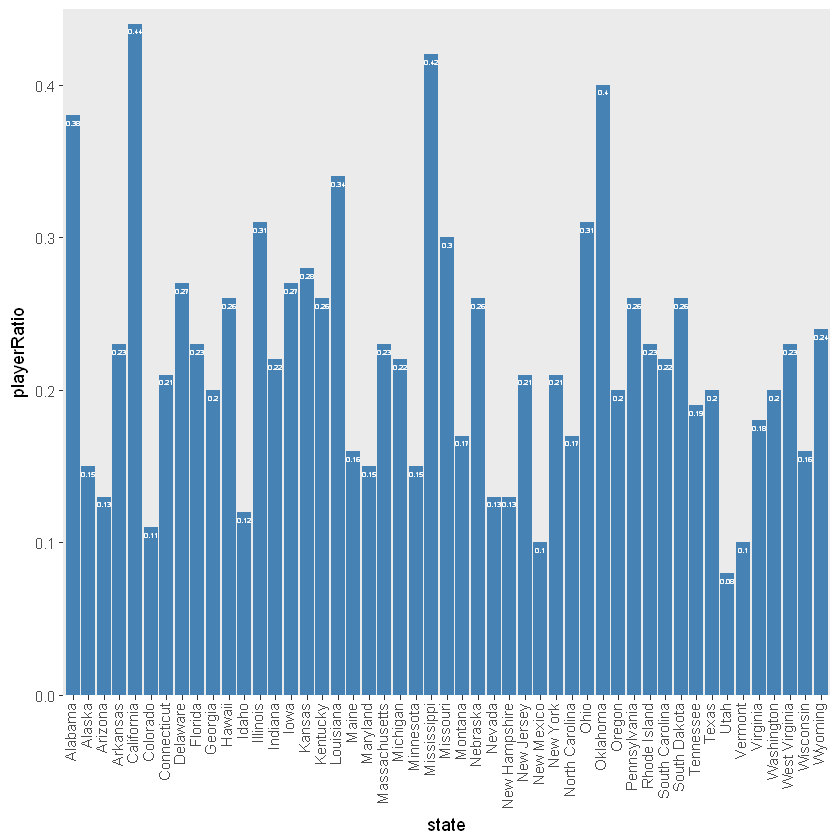

In [19]:
## barplot of ratio of state population to number of players from that state
states_players_pop$playerRatio <- round(states_players_pop$playersTotal / states_players_pop$popEstimate, 2)
states_ratio <- states_players_pop[c('state','playerRatio')]

ratio_plot <- ggplot(data=states_ratio, aes(x = state, y = playerRatio)) +
                geom_bar(stat='identity', fill = 'steelblue') + 
                geom_text(aes(label = playerRatio), vjust = 1.6, color = 'white', size = 1.5) +
                theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .2)) +
                scale_y_continuous(limits = c(0, 0.45), expand = c(0,0)) +
                theme(panel.grid = element_blank(), panel.border = element_blank())
ratio_plot

head(states_ratio[order(-states_ratio$playerRatio),])

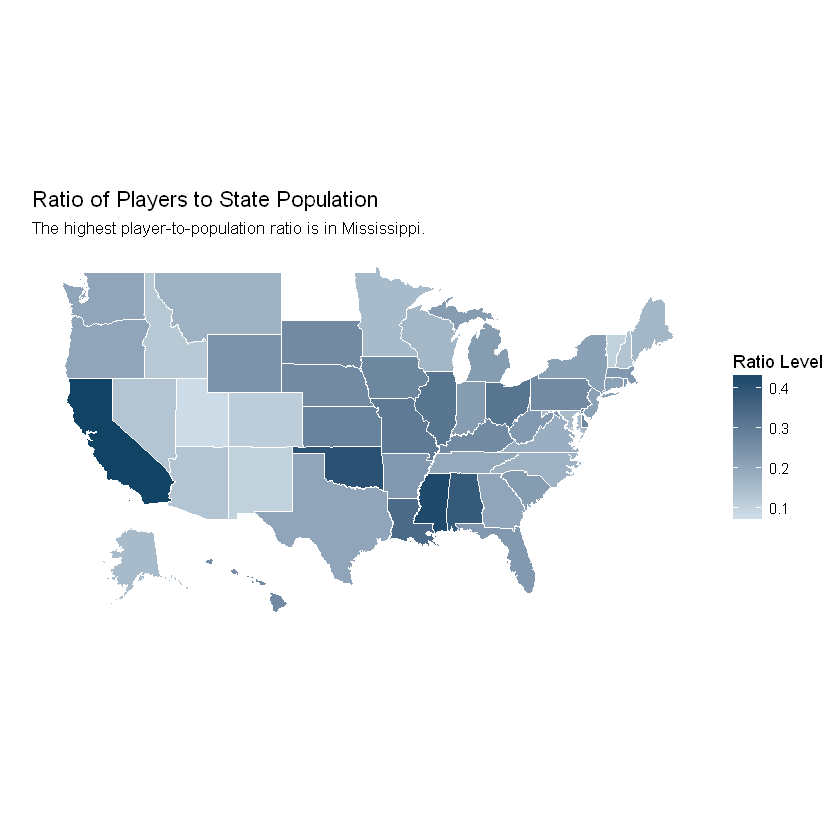

In [20]:
####################################
# chloropleth map of state player-to-pop ratios
####################################
low_color='#ccdbe5' 
high_color="#114365"
legend_title = 'Ratio Level'
ggplot(states_ratio, aes(map_id = tolower(state))) + 
  geom_map(aes(fill = playerRatio),color="#ffffff",size=.15, map = fifty_states) + 
  expand_limits(x = fifty_states$long, y = fifty_states$lat) +
  coord_map() +
  labs(x = "", y = "") +
  scale_x_continuous(breaks = NULL) + 
  scale_y_continuous(breaks = NULL) +
  scale_fill_continuous(low = low_color, high= high_color, guide = guide_colorbar(title = legend_title)) + # creates shading pattern
  theme(#legend.position = "bottom", 
    panel.background = element_blank()) + 
  #fifty_states_inset_boxes() +
  ggtitle('Ratio of Players to State Population', subtitle = 'The highest player-to-population ratio is in Mississippi.')

In [21]:
## code to group statistics by year rather than by player
batting_by_year <- group_by(Batting, yearID)

batting_years <- summarise(batting_by_year, H = sum(H), AB = sum(AB), G = sum(G), R = sum(R),
                           X2B = sum(X2B), X3B = sum(X3B), HR = sum(HR), RBI = sum(RBI),
                           SB = sum(SB), CS = sum(CS), BB = sum(BB), SO = sum(SO), totalPlayers =n())
head(batting_years)
## group the data frame by playerID

yearID,H,AB,G,R,X2B,X3B,HR,RBI,SB,CS,BB,SO,totalPlayers
1871,3101,10822,2296,2659,434,239,47,1783,441,123,393,175,115
1872,4487,15679,3307,3390,567,139,35,2103,254,118,247,252,156
1873,4923,16974,3603,3580,556,208,46,2339,175,99,322,243,125
1874,5226,19104,4199,3470,633,194,40,2249,226,91,236,345,123
1875,6812,26833,6249,4234,839,273,40,2710,629,320,249,675,218
1876,5338,20121,4696,3066,633,181,40,1984,NA,NA,336,589,124


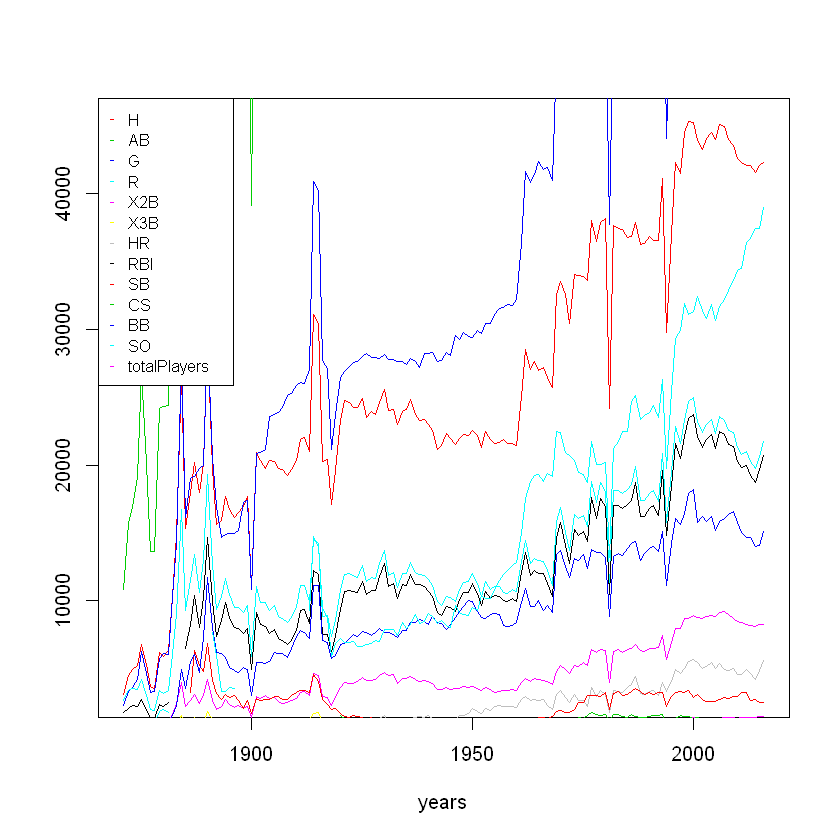

In [22]:
## plot all continuous variables by year on same plot

i <- 2

while (i <= length(batting_years)) {
    if (i == 2) {
        plot(batting_years$yearID, batting_years[[i]], xlab = 'years', ylab='', type = 'l', col = i)
    } else {
        lines(batting_years$yearID, batting_years[[i]], type = 'l', ylab='', col = i)
    }
    i = i + 1
}
legend('topleft', legend = colnames(batting_years[,2:length(batting_years)]), 
       col = 2:length(batting_years), pch='-', cex = 0.8)

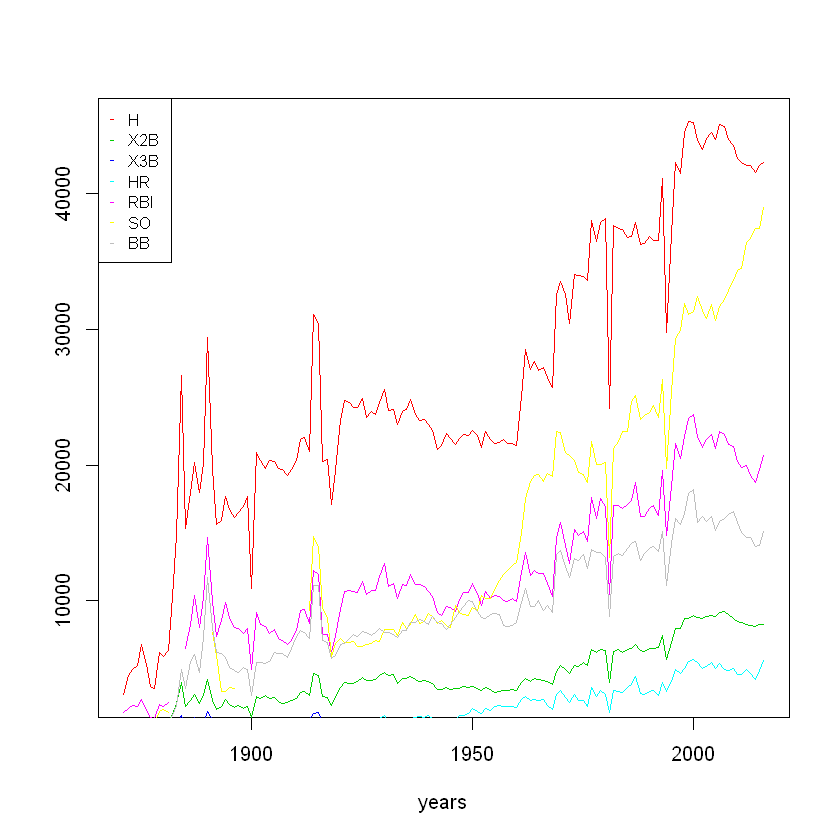

In [23]:
to_plot <- batting_years[,c('yearID', 'H', 'X2B', 'X3B', 'HR', 'RBI', 'SO', 'BB')]

i <- 2

while (i <= length(to_plot)) {
    x = to_plot$yearID
    y = to_plot[[i]]
    if (i == 2) {
        plot(x, y, xlab = 'years', ylab='', type = 'l', col = i)
    } else {
        lines(x, y, type = 'l', ylab='', col = i)
    }
    i = i + 1
}
legend('topleft', legend = colnames(to_plot[,2:length(to_plot)]), 
       col = 2:length(to_plot), pch='-', cex = 0.8)

# Using R to Analyze the Lahman 2016 Data set

## What is The Lahman dataset?
* It is a dataset that was created, and is still maintained by, Sean Lahman. It contains baseball statistics going back to 1871 - yes, **1871**!

* There actually is an R "Lahman" package that "provides the tables from the 'Sean Lahman Baseball Database' as a set of R data.frames"
    * for more information, check out the [Lahman R Package](https://cran.r-project.org/web/packages/Lahman/index.html)

# Questions I tried to answer
1. Is there a significance between a player's batting average (the number of hits divided by the number of at-bats) and the hand which with they bat? I.e., right-handed, left-handed, or both.
    - H<sub>0</sub>: there is no statistical significance between a player's batting average and with their dominant batting hand
    - H<sub>1</sub>: there does exist a significance.


2. Is it possible to identify certain characteristics about the different fielding positions based on the average batting statistics for players of that position?
    - H<sub>0</sub>: there are no definiing batting characteristics by position.
    - H<sub>1</sub>: there do exist some batting characteristics for players of a certain position

# Univariate Statistical Analysis
First, we will attempt to answer the question, 
*"Is there a significance between a player's batting average and their batting hand?"*
using univariate statistical models.

In [24]:
#import requisite ilbraries
require('dplyr')

#import the data
library(Lahman)

#get the data
batting = merge(Master, Batting, by='playerID')

In [25]:
#First, CLEAN the data
## remove records with NA in the "bats" column (this is the player's batting hand)
batting = batting[!is.na(batting$bats),]

## remove all records before 1961 (1961 was the year the "modern" baseball season 
## of 162 games started, including prior years may skew results)
batting = batting[batting$yearID >= 1961,]

## Calculate batting average and include it as a new column in the data frame
batting$BA = batting$H / batting$AB

## remove records with no batting average and where batting average is above some 
## threshold - in this case 0.1
batting = batting[!is.na(batting$BA) & batting$BA >= 0.1,]

## name the columns
batting = batting[,c('playerID', 'birthYear', 'birthMonth', 'birthDay', 
                     'birthCity', 'birthState', 'birthCountry', 'nameFirst', 
                     'nameLast', 'weight', 'height', 'bats', 'throws', 'G', 
                     'AB', 'H', 'BA')]

## include a column for the player's entire name 
## (concatenation of nameFirst and nameLast columns)
batting$fullName =  paste(batting$nameFirst, batting$nameLast)

In [26]:
## select only the columns we'll use for this analysis
batting_df = select(batting, playerID, G:BA)

## group the data frame by playerID
players = group_by(batting_df, playerID)

## summarize player information - creates one row for each player 
## (originally have one row for each year a player played)
players = summarise(players, H = sum(H), AB = sum(AB), G = sum(G), 
                    BA = round(mean(BA), 3), total_rows = n())

## drop any duplicate records from the batting data frame
deduped_batting <- batting[!duplicated(batting$playerID),]

## merge the deduplicated batting dataframe with the player dataframe 
## containing only one row per player
new_batting = merge(players, deduped_batting, by="playerID")

## select only the columns we want in this new data frame
new_batting = select(new_batting, playerID:throws, fullName)

## name the columns
colnames(new_batting) = c('playerID','H','AB','G','BA','totalYears','birthYear',
                          'birthMonth','birthDay','birthCity','birthState',
                          'birthCountry','nameFirst','nameLast','weight','height',
                          'bats','throws','fullName')

## remove any records where the player played less than 162 games 
## (that would be less than one season, so could also skew data, could have 
## abnormally high or low batting average based on limited number of at bats.)
new_batting = new_batting[new_batting$G >= 162,]

## Let's get an idea of what our batting data frame looks like

In [27]:
head(new_batting)

,playerID,H,AB,G,BA,totalYears,birthYear,birthMonth,birthDay,birthCity,birthState,birthCountry,nameFirst,nameLast,weight,height,bats,throws,fullName
1,aaronha01,2462,8250,2259,0.294,16,1934,2,5,Mobile,AL,USA,Hank,Aaron,180,72,R,R,Hank Aaron
2,aaronto01,216,944,437,0.221,7,1939,8,5,Mobile,AL,USA,Tommie,Aaron,190,75,R,R,Tommie Aaron
5,abbotje01,157,596,233,0.247,5,1972,8,17,Atlanta,GA,USA,Jeff,Abbott,190,74,R,L,Jeff Abbott
6,abbotku01,523,2044,702,0.251,10,1969,6,2,Zanesville,OH,USA,Kurt,Abbott,180,71,R,R,Kurt Abbott
9,abercre01,86,386,180,0.239,3,1980,7,15,Columbus,GA,USA,Reggie,Abercrombie,215,75,R,R,Reggie Abercrombie
10,abernbr01,210,834,220,0.250,3,1977,9,23,Atlanta,GA,USA,Brent,Abernathy,185,73,R,R,Brent Abernathy


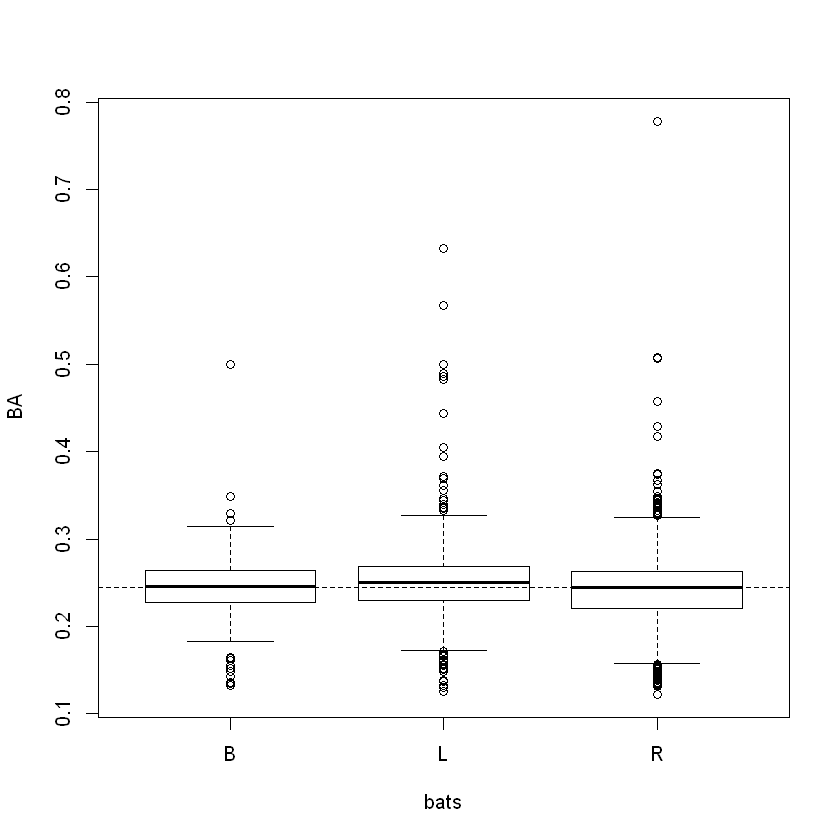

In [28]:
## find the batting average mean across all players
BA_mean = mean(new_batting$BA)

## plot batting average against batting hand
plot(BA ~ bats, new_batting)

## include a line representing the mean generated above
abline(h = BA_mean, lty=2)

In [29]:
#build the linear model
model1 = lm(BA ~ bats, data = new_batting)

#summarize the model results
summary(model1)


Call:
lm(formula = BA ~ bats, data = new_batting)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.12413 -0.02001  0.00187  0.01999  0.53599 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.245120   0.002006 122.173   <2e-16 ***
batsL        0.005007   0.002378   2.105   0.0353 *  
batsR       -0.003110   0.002209  -1.408   0.1592    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03967 on 3199 degrees of freedom
Multiple R-squared:  0.008232,	Adjusted R-squared:  0.007612 
F-statistic: 13.28 on 2 and 3199 DF,  p-value: 1.812e-06


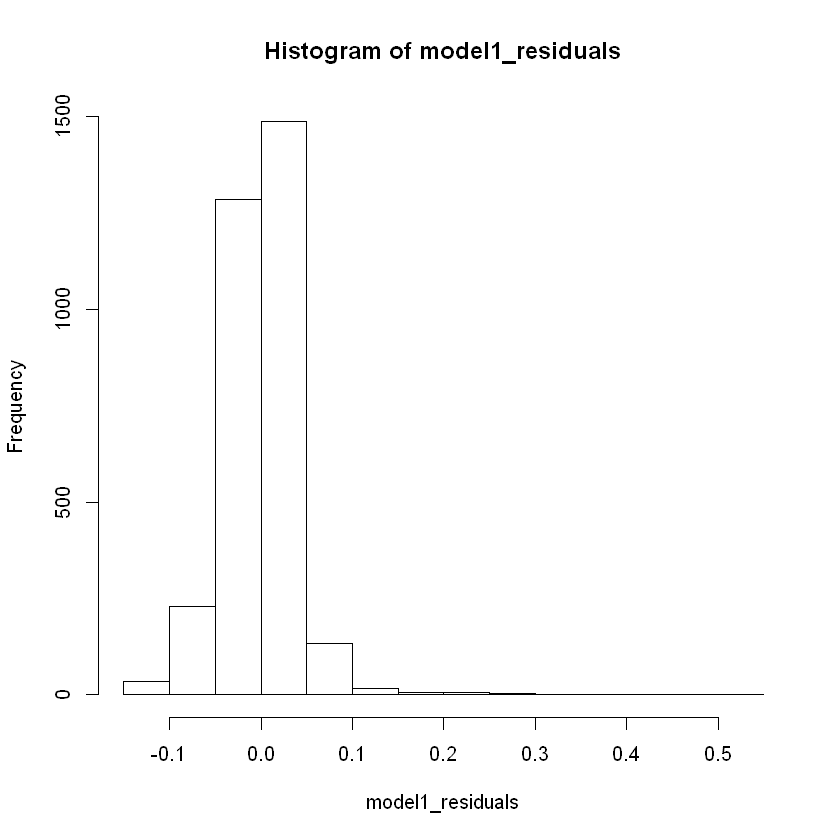

In [30]:
#get model residuals
model1_residuals = model1$residuals

#histogram of residuals
hist(model1_residuals)

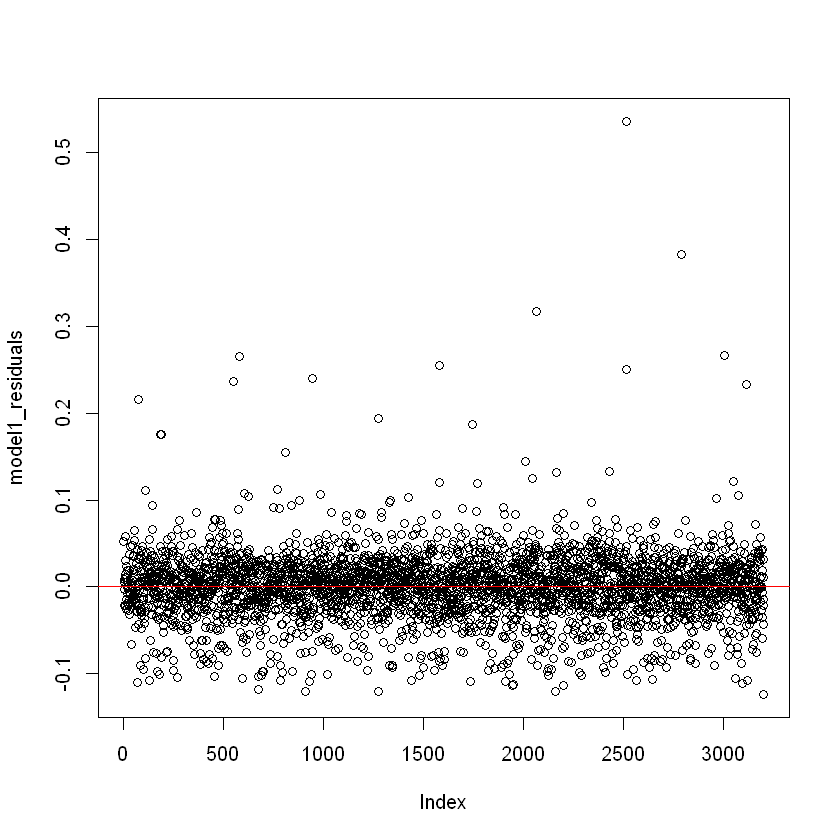

In [31]:
#plot residuals
plot(model1_residuals)
abline(h=0, col=2)

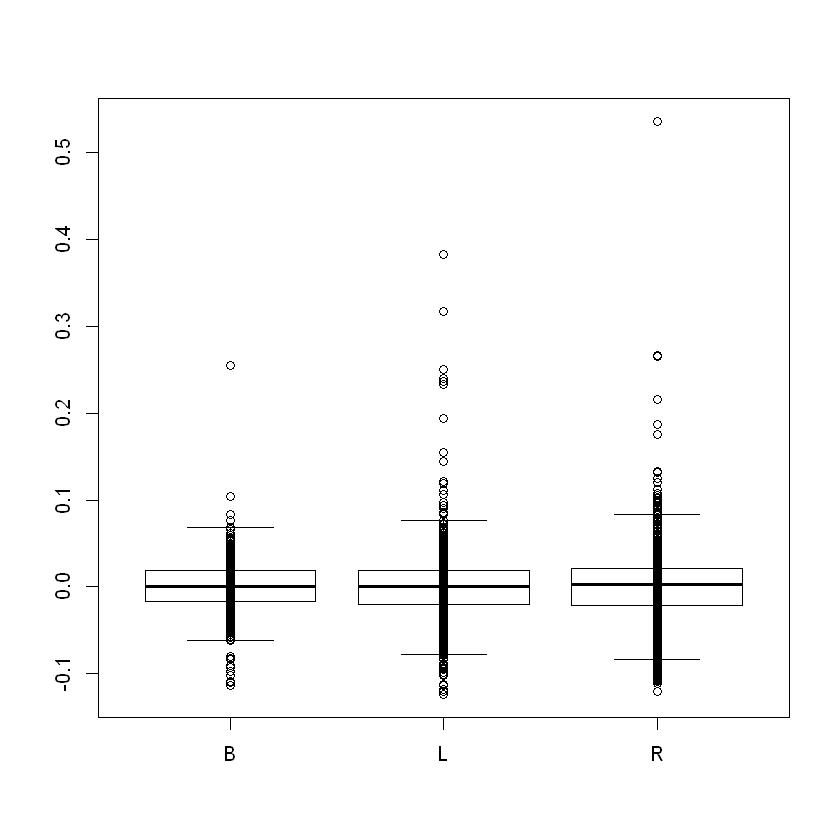

In [32]:
#plot residuals by group (in this case, by batting hand)
plot(new_batting$bats, model1_residuals)
points(new_batting$bats, model1_residuals)

In [33]:
# Run Analysis of Variance on the model
anova(model1)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
bats,2,0.04179077,0.020895386,13.27594,1.811871e-06
Residuals,3199,5.03499748,0.001573929,NA,NA


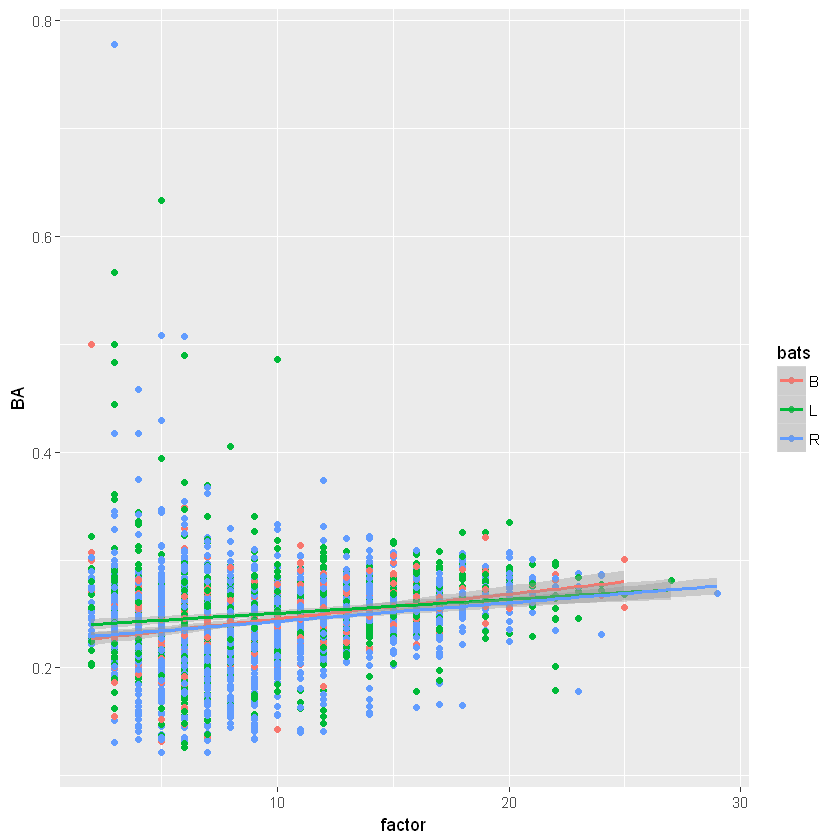

In [34]:
library(ggplot2)

##enter continuous variable that may be impacting the batting average
factor = new_batting$totalYears

##plot the affect of the factor
ggplot(new_batting, aes(x = factor, y = BA)) + 
    geom_point(aes(color = bats)) + 
    geom_smooth(aes(color = bats), method = 'lm')


In [35]:
##generate new model with additional column factor 
## (non-factorial/categorial, continuous) taken into account
model2 = lm(BA ~ bats + factor, data = new_batting)

# Check out the model summary
summary(model2)


Call:
lm(formula = BA ~ bats + factor, data = new_batting)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.11821 -0.01789  0.00048  0.01828  0.54655 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.2287829  0.0024621  92.920   <2e-16 ***
batsL        0.0054940  0.0023349   2.353   0.0187 *  
batsR       -0.0023049  0.0021691  -1.063   0.2880    
factor       0.0016557  0.0001498  11.056   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03894 on 3198 degrees of freedom
Multiple R-squared:  0.04474,	Adjusted R-squared:  0.04384 
F-statistic: 49.93 on 3 and 3198 DF,  p-value: < 2.2e-16


In [36]:
# Run Analysis of Variance on the model
anova(model2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
bats,2,0.04179077,0.020895386,13.77903,1.100224e-06
factor,1,0.18534853,0.185348533,122.22423,6.560717e-28
Residuals,3198,4.84964894,0.001516463,NA,NA


# Takeaways?

- Based on the linear model summary, there does seem to be some relationship between a player being able to bat with both hands and their batting average. 
- At least everything is normally distributed!

# Multivariate Statistical Analysis
Now, we will explore the question *"Is it possible to identify certain characteristics about the different fielding positions based on the average batting statistics for players of that position?"* using multivariate statistics.

In [37]:
#import the same libraries and data
require('dplyr')

library(Lahman)

# generate the batting dataframe again - we'll be using it 
## in a different way this time!
batting = merge(Master, Batting, by='playerID')

In [38]:
## do the same cleansing and calculations on the batting dataframe 
## as before, this time only going until 2000
batting = batting[!is.na(batting$bats),]
batting = batting[batting$yearID >= 2000,]
batting$BA = batting$H / batting$AB
batting = batting[!is.na(batting$BA) & batting$BA >= 0.1,]

In [39]:
## this time, load in a new dataframe, the Fielding dataframe 
## (to get player's positions)
## get records only after 2000
new_fielding = Fielding[Fielding$yearID >= 2000,]

## reduce the dataframe to only those rows in which we are interested
new_fielding <- new_fielding[c('playerID','POS','yearID')]

In [40]:
## merge the batting and fielding dataframes 
## (gets position names with players)
pos_batting <- merge(new_fielding, batting, 
                     by = c('playerID','yearID'))

## this time, group by Position rather than by Player
pos_stats <- group_by(pos_batting, POS)

## build a summary dataframe that summarizes statistics by position
pos_stats = summarise(pos_stats, BA = round(mean(BA), 3),
                      X2B = sum(X2B), X3B = sum(X3B), HR = sum(HR), 
                      RBI = sum(RBI), BB = sum(BB), SO = sum(SO), 
                      SB = sum(SB))

## set the rownames to the Position names and remove the 
## POS column from the dataframe
rownames(pos_stats) <- pos_stats$POS
pos_stats$POS <- NULL

Warning message:
"Setting row names on a tibble is deprecated."

In [41]:
# check out the dataframe - now we have one row for each fielding position
pos_stats

,BA,X2B,X3B,HR,RBI,BB,SO,SB
1B,0.249,44898,3038,30323,117913,87438,171027,6322
2B,0.247,33335,4213,13608,70477,55265,115881,13343
3B,0.245,36280,3438,19857,87140,62505,136038,8805
C,0.242,18196,912,10175,45182,31514,72145,1578
OF,0.250,75389,9659,45785,184294,140107,299817,32706
P,0.260,3282,247,1107,7598,5085,29196,436
SS,0.248,28990,3943,11842,62229,46122,101384,12252


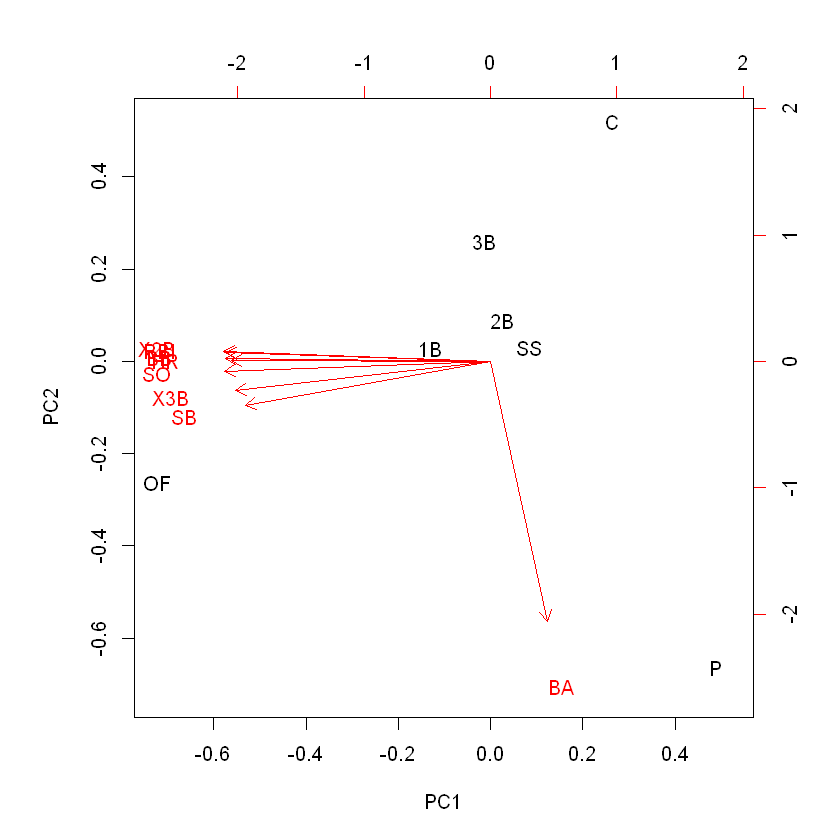

In [42]:
## prcomp the data!
model2<-prcomp(pos_stats,scale=T,center=T)
biplot(model2)

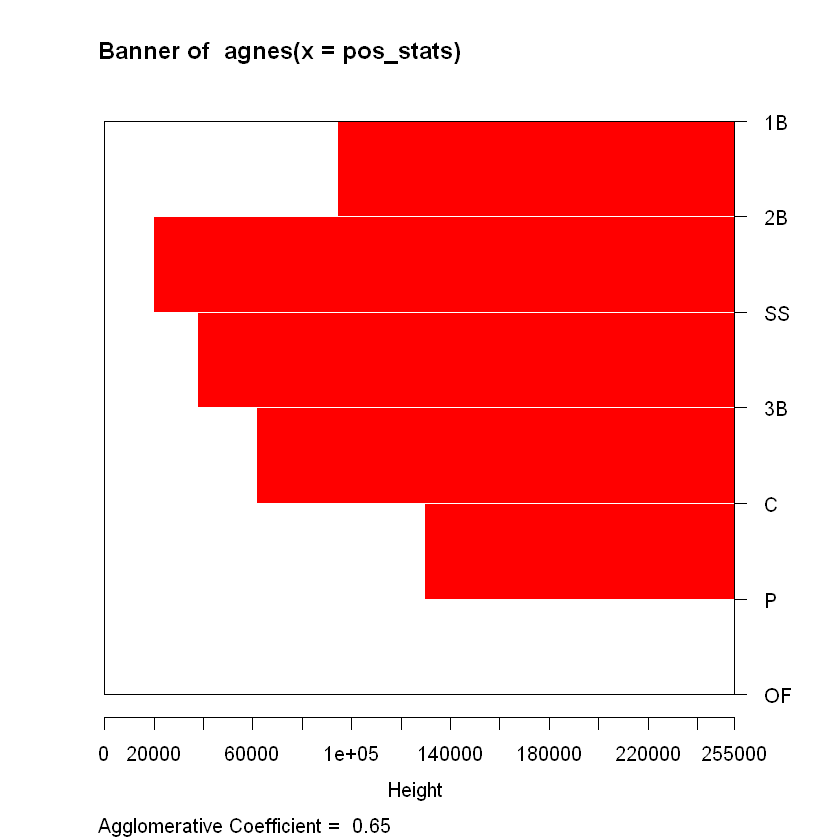

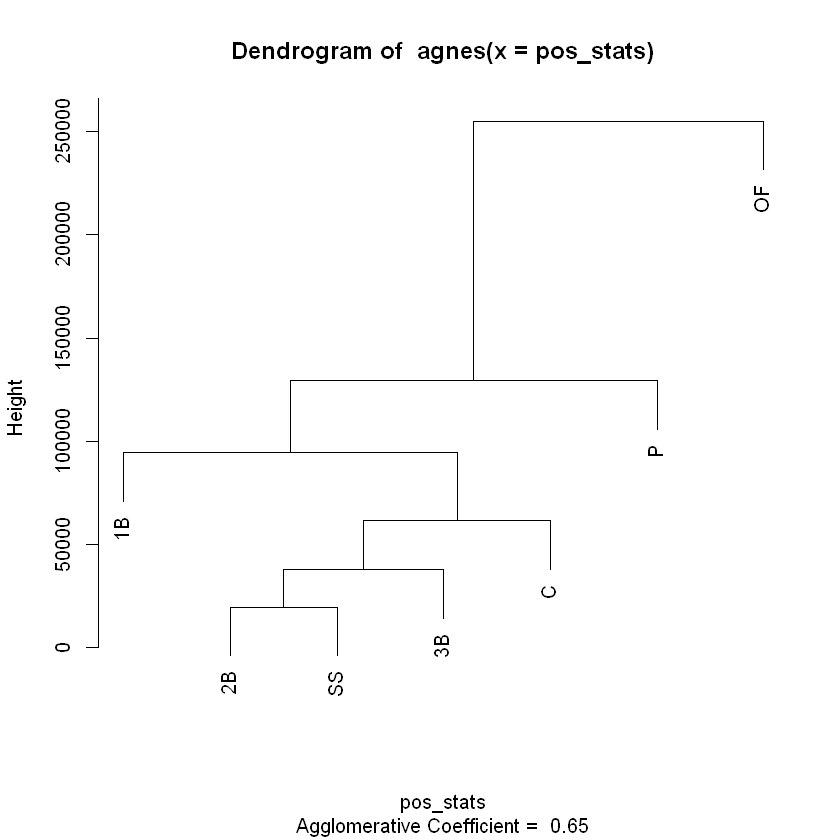

In [43]:
## let's try an agnes
library(cluster)

pos_cluster <- agnes(pos_stats)
plot(pos_cluster)

## Initial Thoughts?

- There doesn't seem to be much we can get from the information we have - we can say something about Outfielders (OF) and Pitchers (P), but not much else in regards to tne other positions.

- let's add some more information: typically people who are right- or left-handed play certain positions (first basement - 1B - for example, are very often left-handed). Let's include batting and throwing handedness into the mix and see if that affects our results

In [44]:
## create batting and throwing columns based on player dominant hand
pos_batting_hand = within(pos_batting, {
    bats_left = ifelse(bats == 'L', 1, 0)
    bats_right = ifelse(bats == 'R', 1, 0)
    bats_both = ifelse(bats == 'B', 1, 0)
    throws_left = ifelse(throws == 'L', 1, 0)
    throws_right = ifelse(throws == 'R', 1, 0)
 })

In [45]:
## follow the same procedures as before to summarize the data 
## by position; this time, include the columns relating
## to player's batting and throwing handedness
pos_stats_hand <- group_by(pos_batting_hand, POS)
pos_stats_hand = summarise(pos_stats_hand, BA = round(mean(BA), 3),
                           X2B = sum(X2B), X3B = sum(X3B), HR = sum(HR), 
                           RBI = sum(RBI), BB = sum(BB), SO = sum(SO), 
                           SB = sum(SB), throws_left = sum(throws_left), 
                           throws_right = sum(throws_right), 
                           bats_left = sum(bats_left), 
                           bats_right = sum(bats_right), 
                           bats_both = sum(bats_both))

rownames(pos_stats_hand) <- pos_stats_hand$POS
pos_stats_hand$POS <- NULL

Warning message:
"Setting row names on a tibble is deprecated."

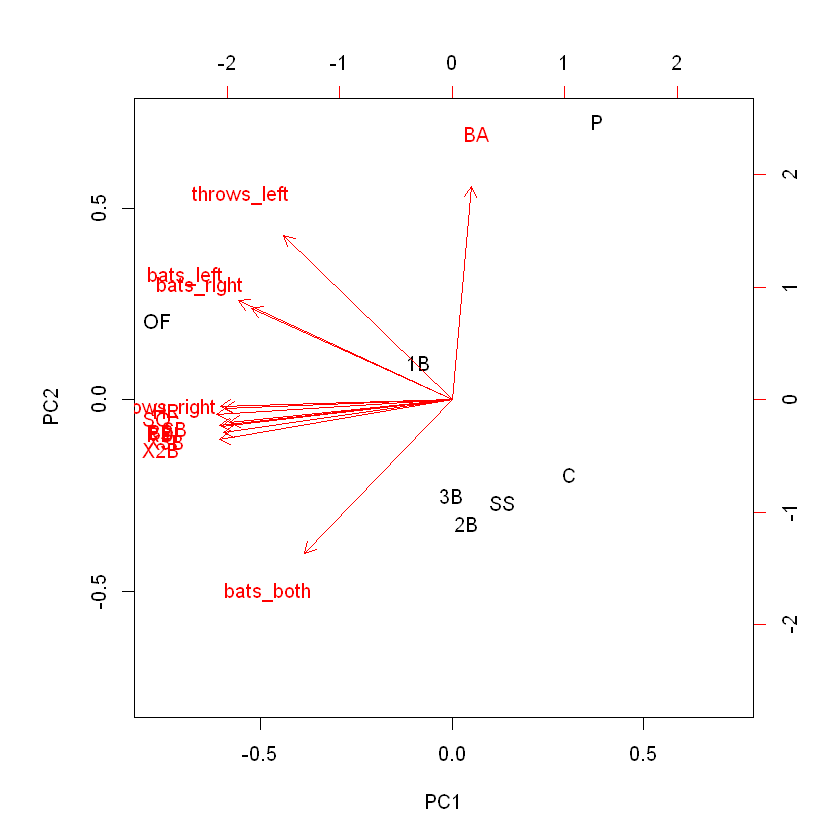

In [46]:
## run prcomp again, this time with the new model
handmodel<-prcomp(pos_stats_hand,scale=T,center=T)
biplot(handmodel)

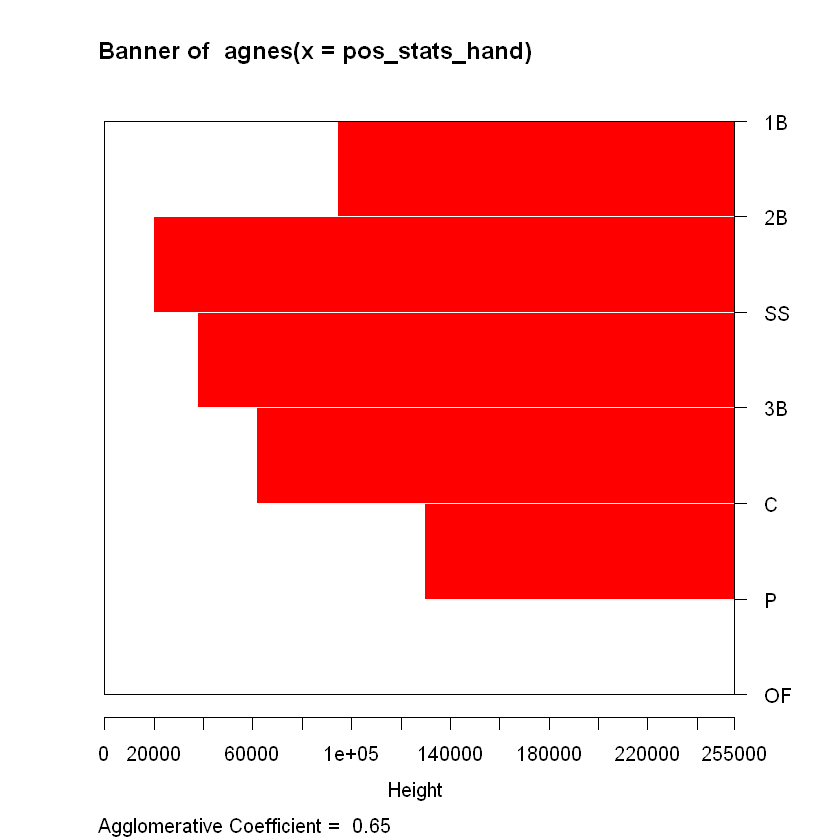

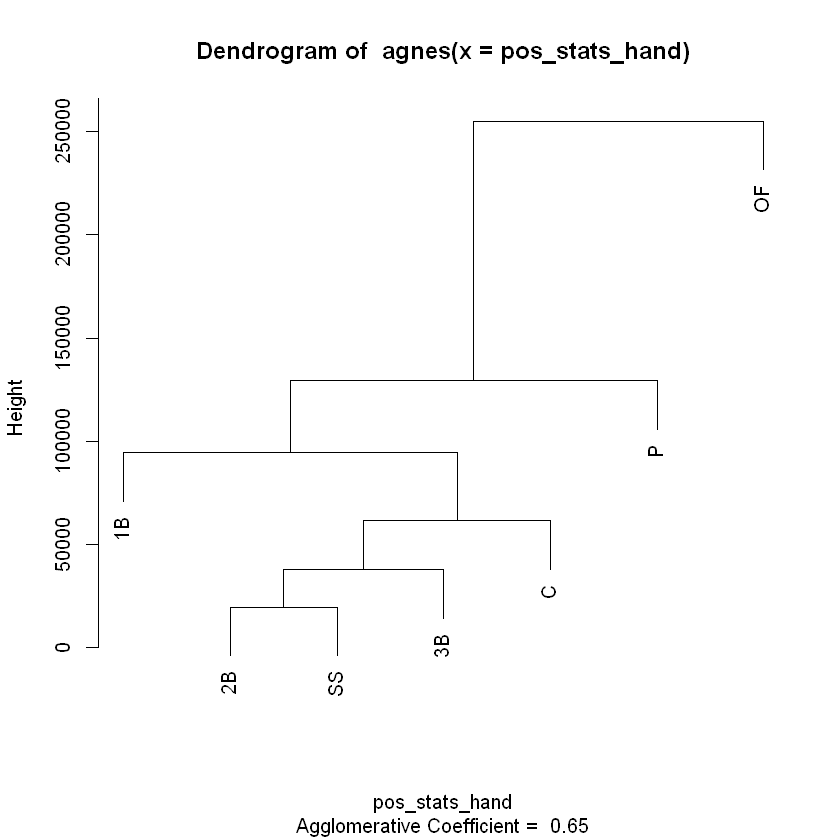

In [47]:
## run agnes again, this time with the new model
handcluster <- agnes(pos_stats_hand)
plot(handcluster)

# Impacts?

- some...but nothing too revealing.
    - At least we confirmed that first basemen are correlated with being left-handed!

# What if we remove OF?
This position is actually an amalgamation of 3 positions - Left Field, Right Field, and Center Field. It looks like it's pulling all the information to one side because it has so much more weight than the other positions. Let's try prcomp again without OF included.

Warning message:
"Setting row names on a tibble is deprecated."

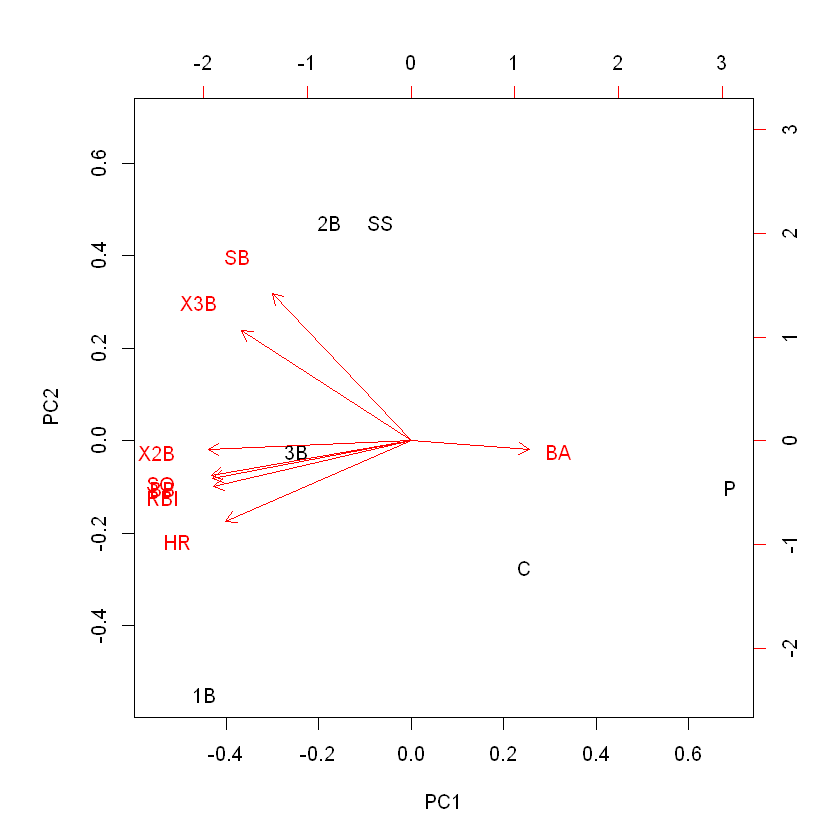

In [48]:
## first, prcomp without OF and handedness
pos_stats_no_of <- pos_stats[!rownames(pos_stats) %in% c('OF'), ]
rownames(pos_stats_no_of) <- c('1B','2B','3B','C','P','SS')

model3<-prcomp(pos_stats_no_of,scale=T,center=T)
biplot(model3)

Warning message:
"Setting row names on a tibble is deprecated."

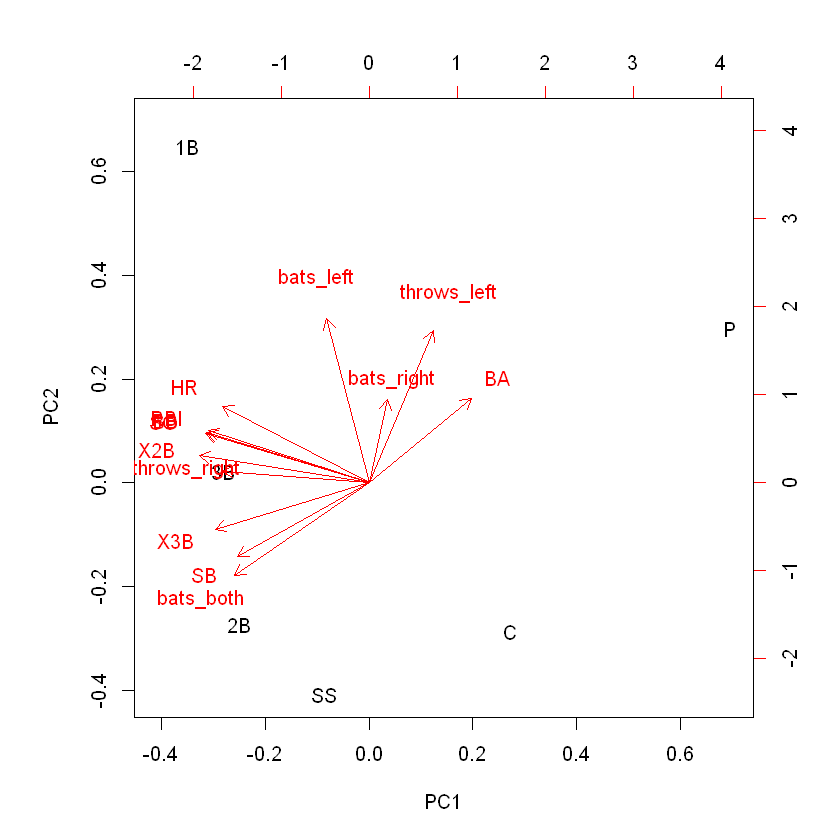

In [49]:
## now, let's try it again without OF and with handedness

pos_stats_no_of_hand <- pos_stats_hand[!rownames(pos_stats_hand)
                                       %in% c('OF'), ]
rownames(pos_stats_no_of_hand) <- c('1B','2B','3B','C','P','SS')

handmodel_no_of <-prcomp(pos_stats_no_of_hand,scale=T,center=T)
biplot(handmodel_no_of)

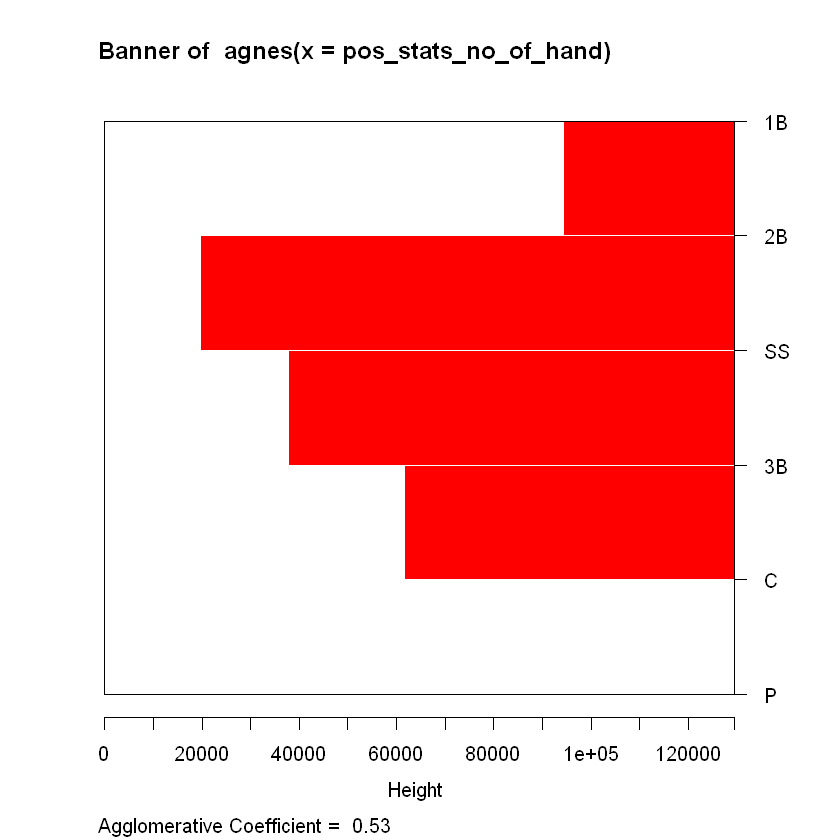

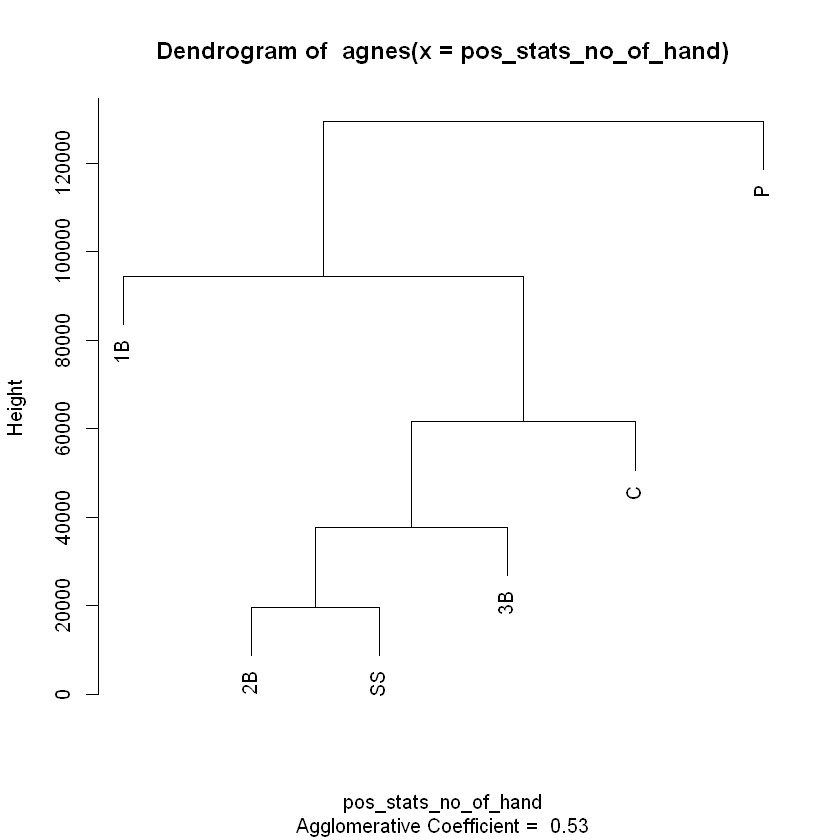

In [50]:
## run agnes again, this time with the new model
handcluster_no_of <- agnes(pos_stats_no_of_hand)
plot(handcluster_no_of)

# And Now?

- The remainig positions are certainly more spread out after removing OF
- Does it make things more clear? Somewhat.

# What's Next?

- are some positions being over-represented? Some positions are more represented in the population than others.
    - fix this by random sampling, take total from each that is equal to the position with the least number of players?

- Not really sure what steps to take next...